In [81]:
suppressPackageStartupMessages({
    source('../R/utils.R')
    library(singlecellmethods)
})

# Simple simulations

## Generating counts with batch and exposure

- 1 cell type
- 2 batches
- variable exposure

$\frac{y}{L} \sim Pois(1 + X)$

$\log(\mu) = \beta_0 + \beta^TX + \log(L)$

$\beta_{0g}$ is the average frequency for gene $g$. We can sample $\beta_0$ from a Gaussian, with some fixed variance.

$\beta_{0g} \sim \mathcal{N}(\log(\mu_g) - \log(L), \sigma^2)$

The donor term should be fixed within some range, defined by $\sigma^2$ below. Let's say that donor effect can change expression by $10\%$. then 

\begin{align}
.9 < \exp(\beta_{donor}) < 1.1 \\
\log(.9) < \beta_{donor} < \log(1.1) \\
\sigma_{donor} = |\log(1.1)|
\end{align}

$\beta_{donor} \sim \mathcal{N}(0, \sigma^2)$

We can expect that $\beta_{donor}$ is mean centered, so that $\mathbb{E} \beta_{donor} = 0$. 


In [4]:
depth <- 1e4
ndonors <- 3

mu <- 5 ## number of counts for gene g
b0 <- rnorm(1, log(mu) - log(depth), sd = abs(log(1.05)))

## donor specific means
bdonor <- rnorm(ndonors, 0, abs(log(1.1)))


Now let's actually get the expected number of counts for gene $g$. It should be centered at $\mu$

$\mathbb{E} y_g = \exp(\beta_0 + \beta_{donor} + \log L)$

In [5]:
exp(b0 + bdonor + log(depth))


[1] 5.507964 5.076861 5.465401

Next, draw gene count for individual cells. The source of randomness here is the exposure and Poisson sampling process


$y_{ig} \sim Pois(L_i \mu_{ig})$


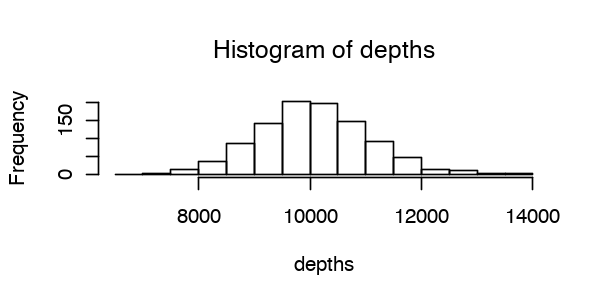

In [7]:
fig.size(2.5, 5)
N <- 1e3
donors <- sample(ndonors, N, TRUE)

## sample depths
depths <- rlnorm(N, log(depth), .1)
hist(depths)

In [8]:
exp(b0 + bdonor + log(depth))

[1] 5.507964 5.076861 5.465401

In [9]:
## expected number per cell
mu_per_cell <- exp(b0 + bdonor[donors] + log(depths))

## draw from Poisson
yg <- rpois(N, mu_per_cell)


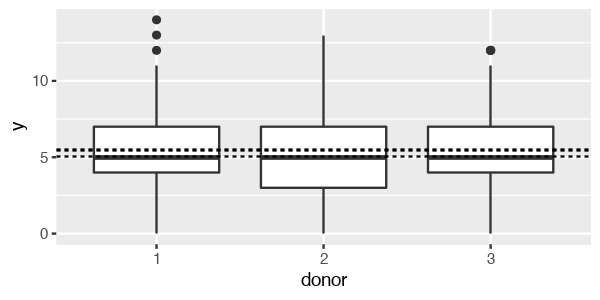

In [10]:
data.table(donor = factor(donors), depth = depths, y = yg) %>% 
    ggplot(aes(donor, y)) + geom_boxplot() + 
        geom_hline(yintercept = exp(b0 + bdonor + log(depth)), linetype = 2)

Finally, sample all the genes. 


For valid Poisson modeling, let's ensure that no genes occurs at $>1\%$


In [15]:
ngenes <- 500
mus <- depth * prop.table(rgamma(ngenes, .5, 1))

100 * min(mus / sum(mus))
100 * max(mus / sum(mus))

[1] 1.367885e-06

[1] 1.403691

In [16]:
params_true <- Reduce(cbind, lapply(mus, function(mu) {
    b0 <- rnorm(1, log(mu) - log(depth), sd = abs(log(1.05)))
    bdonor <- rnorm(ndonors, 0, abs(log(1.1)))
    
    data.frame(c(as.numeric(b0), as.numeric(bdonor)))
})) %>% t %>% 
    data.table
colnames(params_true) <- paste0('b', 1:ncol(params_true))
head(params_true)

b1,b2,b3,b4
<dbl>,<dbl>,<dbl>,<dbl>
-7.368127,-0.0102081798,0.12565455,-0.01934084
-4.926200,-0.2414722454,-0.01331086,0.11636453
-5.230343,0.0006224581,-0.08043056,0.09131474
-6.328255,0.0707043196,-0.01530109,-0.01645984
-6.280816,0.0032114773,-0.01092046,-0.03355794
-5.975050,0.0907248050,0.07113608,-0.01570027


In [17]:
library(profvis)
X <- apply(params_true, 1, function(beta) {
    b0 <- as.numeric(beta[1])
    bdonor <- as.numeric(tail(beta, -1))
    mu_per_cell <- exp(b0 + bdonor[donors] + log(depths))    
    rpois(N, mu_per_cell)
}) %>% t


How much sparsity did we create? 

In [18]:
sum(X == 0) / prod(dim(X))

[1] 0.136618

Confirm that the number of sampled reads is more or less the same as depth (sampled from $\log\mathcal{N}$)

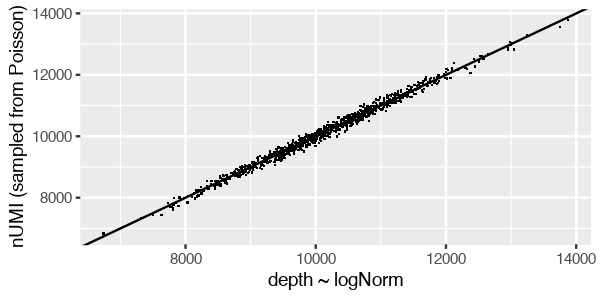

In [19]:
data.table(depth = depths, nUMI = colSums(X)) %>% 
    ggplot(aes(depth, nUMI)) + geom_point(shape = '.') + 
        geom_abline(slope = 1, intercept = 0) + 
        labs(x = 'depth ~ logNorm', y = 'nUMI (sampled from Poisson)')

NOTE for later: when we set the shape parameter in Gamma too low, we get more of a power law distribution and the nUMI vs depth relationship becomes worse, especially for the high expressed genes. This may be related to the deviation from Poisson for high expressed genes. Strangely, high expressed genes are underdispered, so maybe NB is not the right model either. 

We might need to use the logistic GLM for abundant genes. 

## Learning the counts from data 

We can use glmnet directly for Poisson regression. 

In [20]:
design <- model.matrix(~0 + factor(donors))

In [21]:
offset <- log(colSums(X))
pres <- Reduce(cbind, apply(X, 1, function (yvals) {
    if (sum(yvals) == 0) {
        return(data.frame(c(a0 = NA, beta = rep(NA, 3))))
    }
    x <- glmnet::glmnet(
        design, 
        yvals, 
        family = 'poisson', 
        offset = offset,
        alpha = 0)
    lambda_idx <- min(which((diff(x$dev.ratio) / tail(x$dev.ratio, -1)) < .01))
    data.frame(c(a0 = as.numeric(x$a0[lambda_idx]), beta = as.numeric(x$beta[, lambda_idx])))        
}))

pres <- data.table(t(pres))

Can we recover the known $beta_0$ and $beta_{donor}$ values from the generative model? 

Warning message:
“Removed 4 rows containing missing values (geom_point).”

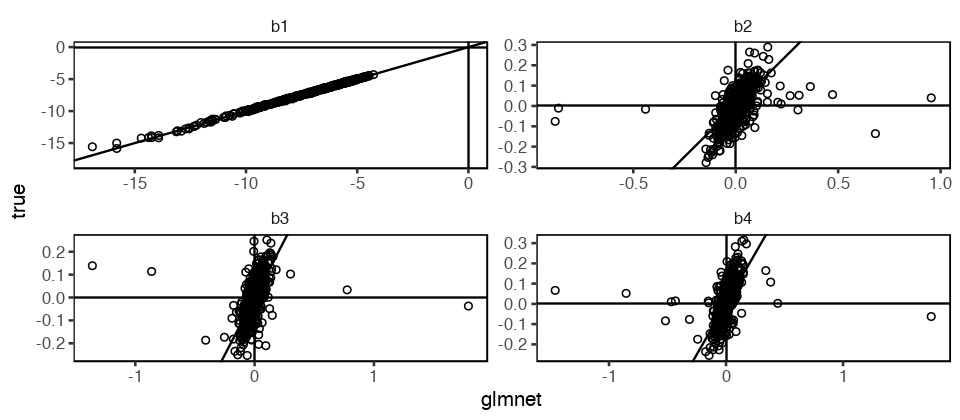

In [22]:
colnames(pres) <- colnames(params_true)
fig.size(3.5, 8)
plt_df <- rbind(
    pres %>% 
        dplyr::mutate(type = 'glmnet') %>% 
        tibble::rowid_to_column('gene'),  
    params_true %>% 
        dplyr::mutate(type = 'true') %>%
        tibble::rowid_to_column('gene')
) %>% 
    tidyr::gather(key, val, -type, -gene) %>%
    tidyr::spread(type, val) 

plt_df %>%
    ggplot(aes(glmnet, true)) + 
        geom_point(shape = 21) + 
        facet_wrap(~key, scales = 'free') + 
        geom_abline(slope = 1, intercept = 0) + 
        theme_tufte(base_size = 12) + 
        theme(panel.background = element_rect()) + 
        geom_hline(yintercept = 0) + 
        geom_vline(xintercept = 0)

Why are some of the values way off? These tend to be the ones that are very lowly expressed. 

In [23]:
genes_bad <- data.table(plt_df)[key == 'b3' & abs(glmnet - true) > .3, gene]
data.table(plt_df)[gene %in% genes_bad] %>% 
    dplyr::select(-glmnet) %>% 
    tidyr::spread(key, true)

gene,b1,b2,b3,b4
<int>,<dbl>,<dbl>,<dbl>,<dbl>
50,-15.85179,-0.13627790,0.03353603,0.06656612
154,-15.58128,-0.07598223,0.11371361,-0.06255127
235,-13.14827,0.03206573,-0.21045871,-0.06274445
338,-14.23223,0.03984308,0.13891617,0.16462103
428,-15.00859,-0.01090770,-0.03732463,0.05207968


## Correcting counts to median exposure

We've modeled $y_g$ in terms of intercept, batch, and exposure. 

$y = exp(\beta_0 + \beta_{donor} + \log L_{cell})$

We can factor the exponential terms: 

$y = exp(\beta_0)\exp(\beta_{donor})L_{cell})$

Now let's remove the batch terms. 

$\hat{y} = y / exp(\beta_{donor})$

Then let's swap out the cell depth for the estimated group depth. 

$\hat{y} = \hat{y} \frac{L_{median}}{L_{cell}}$

What's left is the population depth ($L_{median}$) and mean expression ($\beta_0$). 

$\hat{y} = L_{median}exp(\beta_{0})$

We can also rewrite this as: 

$y/L \sim Pois(\beta_0)$


In [24]:
## remove beta term 
Xhat <- X / exp(tcrossprod(as.matrix(pres[, 2:4]), design))

## swap out cell-depth for group-depth
Xhat <- sweep(Xhat, 2, depth / colSums(X), '*')


In [25]:
X[1:5, 1:5]
Xhat[1:5, 1:5]

6,8,4,4,6
84,93,62,72,86
53,54,58,71,59
15,16,16,24,21
17,20,15,16,17


1,2,3,4,5
5.657483,6.55551,3.334204,3.926446,6.231752
68.186608,80.18278,56.930258,77.855865,76.896245
45.299162,50.96980,46.526010,67.070807,55.546051
14.007170,14.30709,12.398787,21.901700,21.600574
15.589889,17.55670,12.036726,15.119746,17.172357


Is there now less batch effect? 

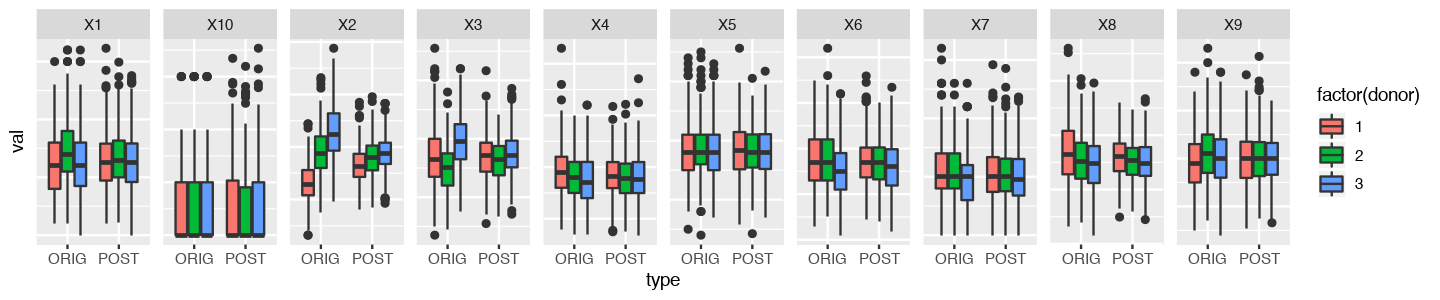

In [26]:
fig.size(2.5, 12)
rbind(
    X[1:10, ] %>% t %>% data.frame %>% 
        cbind(donor = donors) %>% 
        tidyr::gather(key, val, -donor) %>% 
        dplyr::mutate(type = 'ORIG'),
    Xhat[1:10, ] %>% t %>% data.frame %>% 
        cbind(donor = donors) %>% 
        tidyr::gather(key, val, -donor) %>% 
        dplyr::mutate(type = 'POST')
) %>% 
    ggplot(aes(type, val, fill = factor(donor))) + 
        geom_boxplot() +
        facet_wrap(~key, scales = 'free', nrow = 1) + 
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank()) + 
        NULL


## Gather the functions

### To simulate data

TODO: 

    - more than 1 batch variable
    - more than 1 cell type
    - let L be a function of cell type and batch

In [70]:
simulate_meta <- function(N, ndonors=3, prefix='cell') {
    ## batch IDs
    donors <- sample(ndonors, N, TRUE)

    tibble(
        cell_id = paste0(prefix, seq_len(N)),
        donor = donors
    )
}

simulate_counts <- function(meta_data, ngenes=500, depth=1e4, gamma_shape=.5, gamma_rate=1) {
    N <- nrow(meta_data)
    donors <- meta_data$donor
    ndonors <- length(unique(donors))
    
    ## cells depths/exposure
    depths <- rlnorm(N, log(depth), .1)

    ## gene means
    mus <- depth * prop.table(rgamma(ngenes, .5, 1))

    ## simulate rate parameters
    params_true <- Reduce(cbind, lapply(mus, function(mu) {
        b0 <- rnorm(1, log(mu) - log(depth), sd = abs(log(1.05)))
        bdonor <- rnorm(ndonors, 0, abs(log(1.1)))

        data.frame(c(as.numeric(b0), as.numeric(bdonor)))
    })) %>% t %>% 
        data.table
    colnames(params_true) <- paste0('b', 1:ncol(params_true))
    head(params_true)

    ## simulate counts from Poisson
    X <- apply(params_true, 1, function(beta) {
        b0 <- as.numeric(beta[1])
        bdonor <- as.numeric(tail(beta, -1))
        mu_per_cell <- exp(b0 + bdonor[donors] + log(depths))    
        rpois(N, mu_per_cell)
    }) %>% t
    dimnames(X) <- list(genes = paste0('G', 1:nrow(X)), cells = meta_data$cell_id)
    return(X)
}


In [56]:
meta_data <- simulate_meta(1e3, 3, 'cell')
head(meta_data)

cell_id,donor
<chr>,<int>
cell1,1
cell2,2
cell3,1
cell4,2
cell5,3
cell6,2


In [48]:
X <- simulate_counts(meta_data)
X[1:5, 1:5]

,cell1,cell2,cell3,cell4,cell5
G1,5,7,4,6,4
G2,8,5,11,7,11
G3,0,0,0,0,0
G4,24,18,24,27,23
G5,20,10,29,29,25


In [117]:
meta_data <- meta_data %>% 
    dplyr::mutate(nUMI = colSums(X), 
                 nGene = colSums(X != 0))
head(meta_data)

cell_id,donor,nUMI,nGene
<chr>,<int>,<dbl>,<dbl>
cell1,3,9021,424
cell2,2,10693,433
cell3,1,9259,428
cell4,1,9310,424
cell5,3,9968,423
cell6,1,9606,418


### For batch correction


In [57]:
library(glmnet)

correct_counts <- function(X, batches, depths=NULL, lambda_use=NULL, do_cv=FALSE) {
    design <- model.matrix(~0 + factor(batches))
    if (is.null(depths)) depths <- colSums(X)
    pres <- Reduce(cbind, apply(X, 1, function (yvals) {
        if (sum(yvals) == 0) {
            return(data.frame(c(a0 = 0, beta = rep(0, ncol(design)))))
        }
        
        ## CAREFUL: CV is ~15 times slower
        if (do_cv) {
            tryCatch({
                x.cv <- cv.glmnet(design, yvals, family = 'poisson', type.measure = 'deviance',
                                          offset = log(depths), alpha = 0)
                x <- glmnet::glmnet(design, yvals, family = 'poisson', 
                                    offset = log(depths), alpha = 0, lambda = x.cv$lambda.min)
                res <- data.frame(c(a0 = as.numeric(x$a0[1]), beta = as.numeric(x$beta[, 1])))
                return(res)
            }, error = function(e) {
                ## if there are too few non-zero observations to do CV
                ## then don't try to correct that gene
                return(data.frame(c(a0 = 0, beta = rep(0, ncol(design)))))
            })
        } else if (!is.null(lambda_use)) {
            ## Use a predefined lambda for all genes
            x <- glmnet::glmnet(design, yvals, family = 'poisson', lambda = lambda_use,
                                offset = log(depths), alpha = 0)
            res <- data.frame(c(a0 = as.numeric(x$a0[1]), beta = as.numeric(x$beta[, 1]))) 
            return(res)            
        } else {
            ## In this mode, take the smallest value of lambda that gives non-singular solution
            x <- glmnet::glmnet(design, yvals, family = 'poisson', 
                                offset = log(depths), alpha = 0)
            lambda_idx <- which.min(x$lambda)
            res <- data.frame(c(a0 = as.numeric(x$a0[lambda_idx]), beta = as.numeric(x$beta[, lambda_idx]))) 
            return(res)
            
        }
    })) 
    pres <- data.frame(t(pres))
    row.names(pres) <- row.names(X)

    ## remove beta (batch) terms
    Xhat <- X / exp(tcrossprod(as.matrix(pres[, 2:ncol(pres)]), design))

    ## swap out cell-depth for group-depth
    Xhat <- sweep(Xhat, 2, median(depths) / colSums(X), '*')
    dimnames(Xhat) <- dimnames(X)
    
    return(Xhat)
}

In [58]:
Xhat <- correct_counts(X, donors)
Xhat[1:5, 1:5]

,cell1,cell2,cell3,cell4,cell5
G1,4.970711,7.038034,4.542214,5.602063,3.559670
G2,7.645893,5.665267,11.582555,6.060367,9.410923
G3,0.000000,0.000000,0.000000,0.000000,0.000000
G4,23.281453,19.926041,25.459599,23.550129,19.972295
G5,21.796545,10.583901,28.644925,23.552494,24.389280


## Example: PCA & UMAP

We certainly took some of the variation out. Does this translate to PCs and to UMAP? 

### Before Correction

In [104]:
meta_data <- simulate_meta(1e3, 3, 'cell')
X <- simulate_counts(meta_data)

In [105]:
genes_use <- which(Matrix::rowSums(X != 0) >= 10)
pca_res <- X[genes_use, ] %>% 
    log1p() %>% 
    singlecellmethods::scaleData() %>% 
    rARPACK::svds(20, 0, 20)
V1 <- pca_res$v %*% diag(pca_res$d)
umap1 <- umap(V1, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
                 min_dist = .1, n_threads = 4, approx_pow = TRUE)


Cells successfully cluster by donor. 

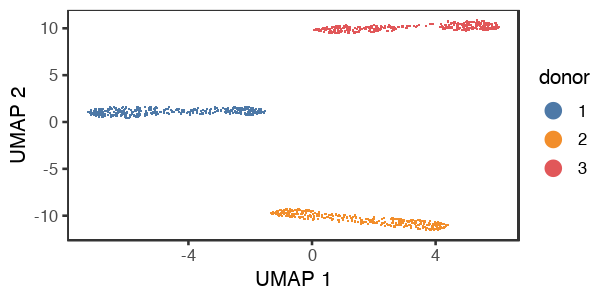

In [108]:
fig.size(2.5, 5)
meta_use <- meta_data %>% dplyr::mutate(donor = factor(donor))
do_scatter(umap1, meta_use, 'donor', do_labels = FALSE, no_guides = FALSE) 

Interesting side point: within donors, cells segregate by read depth/ nUMI/ exposure. 

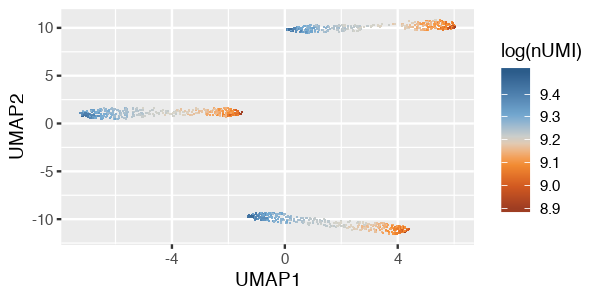

In [109]:
umap1 %>% data.frame() %>% 
    cbind(nUMI = colSums(X)) %>% 
    ggplot(aes(X1, X2, color = log(nUMI))) + 
        geom_point(shape = '.') + 
        labs(x = 'UMAP1', y = 'UMAP2') +
        scale_color_gradient2_tableau() + 
        NULL

### After Correction

In [110]:
Xhat <- correct_counts(X, meta_data$donor)

In [111]:
genes_use <- which(Matrix::rowSums(Xhat != 0) >= 10)
pca_res <- Xhat[genes_use, ] %>% 
    log1p() %>% 
    singlecellmethods::scaleData() %>% 
    rARPACK::svds(20, 0, 20)
V2 <- pca_res$v %*% diag(pca_res$d)
umap2 <- umap(V2, n_neighbors = 30, learning_rate = 0.5, init = "pca", metric = 'cosine', 
                 min_dist = .1, n_threads = 4, approx_pow = TRUE)


After correction, donors are well mixed. 

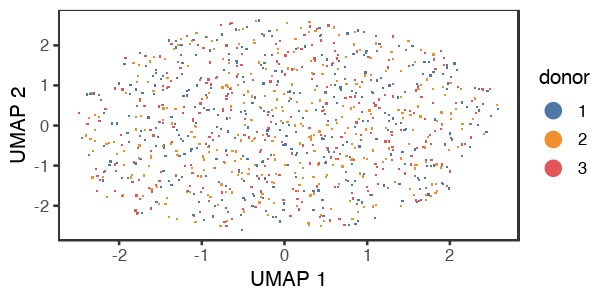

In [112]:
fig.size(2.5, 5)
meta_use <- meta_data %>% dplyr::mutate(donor = factor(donor))
do_scatter(umap2, meta_use, 'donor', do_labels = FALSE, no_guides = FALSE) 

And so is the original read depth. 

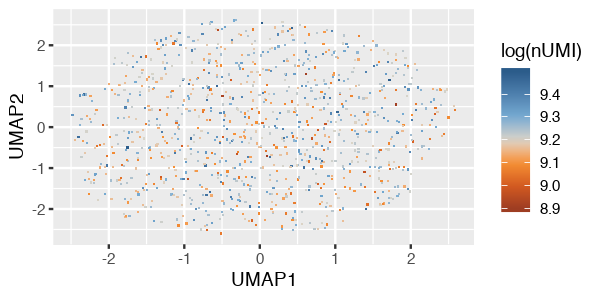

In [115]:
umap2 %>% data.frame() %>% 
    cbind(nUMI = colSums(X)) %>% 
    ggplot(aes(X1, X2, color = log(nUMI))) + 
        geom_point(shape = '.') + 
        labs(x = 'UMAP1', y = 'UMAP2') +
        scale_color_gradient2_tableau() + 
        NULL